# Image classification of the distracted driver data set

## Import Libraries

In [1]:
import pandas as pd
from tqdm import tqdm
import os
import cv2
from glob import glob
import random as rnd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.utils import plot_model
import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Load Data 

In [2]:

data = pd.read_csv('/kaggle/input/distracted-driver-dataset/driver_imgs_list.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [3]:
def loading_data(link,size):
   data_images =[]
   data_labels= []
   for cls in tqdm(range(10)):
       print('loading images in directoy c{}'.format(cls))
       files = glob(os.path.join(str(link)+'/c'+str(cls),'*.jpg'))
       images = rnd.sample(files,1000)
       for image in images:
           img= cv2.imread(image,cv2.IMREAD_COLOR)
           img = cv2.resize(img, size)
           data_images.append(img)
           data_labels.append(cls)
   return data_images,data_labels   

In [4]:
link = '/kaggle/input/distracted-driver-dataset/imgs/train'

X,y= loading_data(link,(227,227))


  0%|          | 0/10 [00:00<?, ?it/s]

loading images in directoy c0


 10%|█         | 1/10 [00:09<01:23,  9.26s/it]

loading images in directoy c1


 20%|██        | 2/10 [00:18<01:12,  9.06s/it]

loading images in directoy c2


 30%|███       | 3/10 [00:27<01:04,  9.22s/it]

loading images in directoy c3


 40%|████      | 4/10 [00:36<00:55,  9.27s/it]

loading images in directoy c4


 50%|█████     | 5/10 [00:46<00:46,  9.21s/it]

loading images in directoy c5


 60%|██████    | 6/10 [00:55<00:37,  9.26s/it]

loading images in directoy c6


 70%|███████   | 7/10 [01:04<00:27,  9.15s/it]

loading images in directoy c7


 80%|████████  | 8/10 [01:13<00:18,  9.19s/it]

loading images in directoy c8


 90%|█████████ | 9/10 [01:22<00:09,  9.17s/it]

loading images in directoy c9


100%|██████████| 10/10 [01:31<00:00,  9.18s/it]


## Data Visualization 

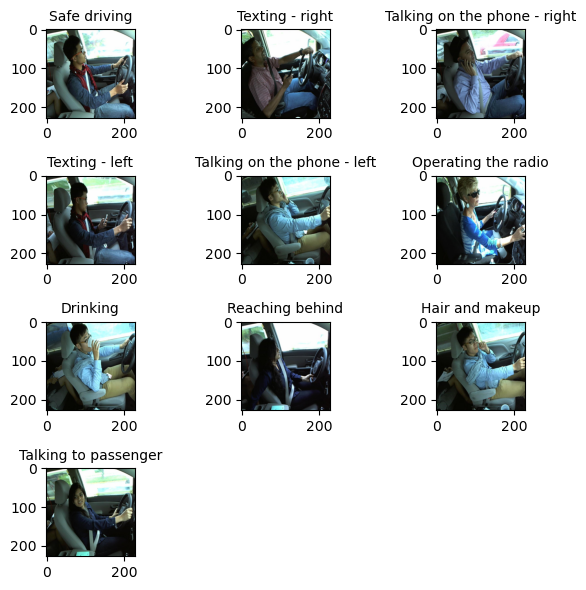

In [19]:
dic = {'c0': 'Safe driving',
                   'c1': 'Texting - right',
                   'c2': 'Talking on the phone - right', 
                   'c3': 'Texting - left', 
                   'c4': 'Talking on the phone - left',
                   'c5': 'Operating the radio', 
                   'c6': 'Drinking',
                   'c7': 'Reaching behind',
                   'c8': 'Hair and makeup', 
                   'c9': 'Talking to passenger'}
plt.figure(figsize = (6,6))
for idx,i in enumerate(data.classname.unique()):
    plt.subplot(4,3,idx+1)
    df = data[data['classname'] ==i].reset_index(drop = True)
    image = df.loc[rnd.randint(0, len(df)), 'img']
    link = '/kaggle/input/distracted-driver-dataset/imgs/train/'+i+'/'+image
    img = Image.open(link)
    img = img.resize((227,227))
    plt.imshow(img)
    plt.title(dic[i],fontsize = 10)
    plt.tight_layout()
plt.show()

## Creation of the Validation Dataset 

In [8]:
y_new= tf.keras.utils.to_categorical(y,num_classes=10)
trainX,testX,trainy,testy= train_test_split(X,y_new,test_size=0.2,random_state=1)
trainX=np.array(trainX,dtype =np.uint8).reshape(-1,227,227,3)
testX=np.array(testX,dtype =np.uint8).reshape(-1,227,227,3)
trainy=np.array(trainy,dtype =np.uint8)
testy=np.array(testy,dtype =np.uint8)

## Design FC Neural Network

In [11]:
model = keras.Sequential(
   [   keras.Input(shape=(227, 227, 3)),
       layers.Flatten(),
       layers.Dense(400, activation ='relu'),
       layers.Dense(400, activation ='relu'),
       layers.Dense(100, activation = 'relu'),
       layers.Dense(10, activation = 'softmax')
       ]
       )
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

   

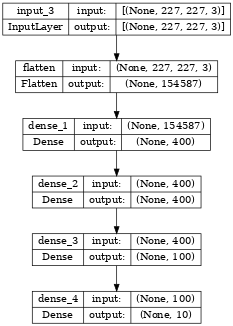

In [16]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='FC_227.png')

In [9]:
def get_model_result():
     accuracy =history.history['accuracy']
     val_accuracy =history.history['val_accuracy']
     loss=history.history['loss']
     val_loss= history.history['val_loss'] 
     result ={'accuracy':[],'val_accuracy':[],'loss':[],'val_loss':[]}
     result['accuracy']= accuracy
     result['val_accuracy']= val_accuracy
     result['loss']=loss
     result['val_loss']= val_loss
     df =pd.DataFrame( data=result)
     return df 

In [13]:
batch_sizes=[ 500, 1500, 3000]
Total_results ={'accuracy':[],'val_accuracy':[],'loss':[],'val_loss':[]}
Total_results = pd.DataFrame(data=Total_results)
for size in batch_sizes: 
     print(size)
     history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=False, batch_size=size)
     df = get_model_result()
     Total_results=pd.concat([Total_results,df])


500
1500
3000


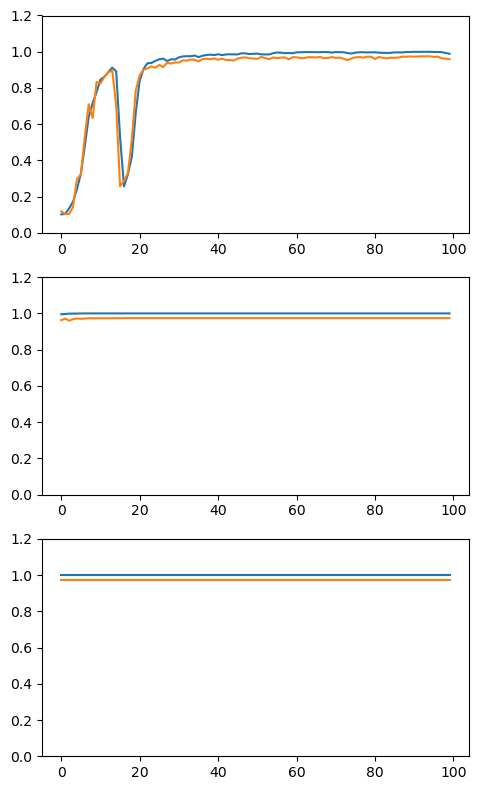

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 8))
fig.tight_layout()
axes =axes.ravel()
i,j =0,0
while j < 3:
     axes[j].plot([i for i in range(100)],Total_results['accuracy'][i:i+100] ,label="train")
     axes[j].plot([i for i in range(100)],Total_results['val_accuracy'][i:i+100] ,label="test")
     axes[j].set_ylim([0, 1.2])
     i=i+100
     j=j+1
    
plt.show()


## FC Neural Network with Batch Normalization  

In [10]:
model_batch_norm = keras.Sequential([
     keras.Input(shape=(227, 227, 3)),
     layers.Flatten(), 
     layers.Dense(400, activation ='relu'),
     layers.BatchNormalization(),
     layers.Dense(400, activation ='relu'),
     layers.BatchNormalization(),
     layers.Dense(100, activation = 'relu'),
     layers.BatchNormalization(),
     layers.Dense(10, activation = 'softmax'),
    ])
model_batch_norm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 154587)            0         
                                                                 
 dense_4 (Dense)             (None, 400)               61835200  
                                                                 
 batch_normalization_3 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 400)               160400    
                                                                 
 batch_normalization_4 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 100)              

In [11]:
model_batch_norm.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


In [12]:
history = model_batch_norm.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=False, batch_size=500)


In [13]:
FC_BN_227 = get_model_result()
FC_BN_227.to_csv('FC_BN_227.csv', index=False)

In [16]:
def plot_model_result(result,fig_title):
    plt.figure(figsize=(5, 3))
    plt.plot([i for i in range(100)],result['accuracy'] ,label="train")
    plt.plot([i for i in range(100)],result['val_accuracy'],label="test")
    plt.ylim([0, 1.2]) 
    plt.show()
    plt.savefig(fig_title)

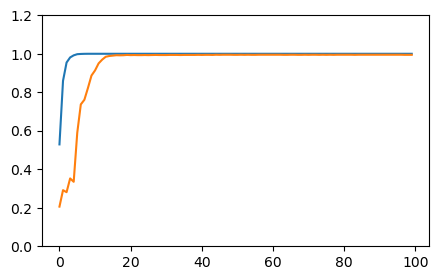

<Figure size 640x480 with 0 Axes>

In [17]:
plot_model_result(result=FC_BN_227, fig_title='FC_BN_227')

## FC Neural Network with Layer Normalization  

In [18]:
model_layer_norm = keras.Sequential([
    keras.Input(shape=(227, 227, 3)),
    layers.Flatten(name ='Flatten'),
    tf.keras.layers.LayerNormalization(name = 'norm_flatten'),
    layers.Dense(400, activation ='relu',name ='layer1'),
    tf.keras.layers.LayerNormalization(name= 'norm_layer1'),
    layers.Dense(400, activation ='relu', name = 'layer2'),
    tf.keras.layers.LayerNormalization(name= 'norm_layer2'),
    layers.Dense(100, activation = 'relu',name = 'layer3'),
    tf.keras.layers.LayerNormalization(name= 'norm_layer3'),
    layers.Dense(10, activation = 'softmax'),
    ] )
model_layer_norm.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model_layer_norm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 154587)            0         
                                                                 
 norm_flatten (LayerNormaliz  (None, 154587)           309174    
 ation)                                                          
                                                                 
 layer1 (Dense)              (None, 400)               61835200  
                                                                 
 norm_layer1 (LayerNormaliza  (None, 400)              800       
 tion)                                                           
                                                                 
 layer2 (Dense)              (None, 400)               160400    
                                                                 
 norm_layer2 (LayerNormaliza  (None, 400)             

In [19]:
history = model_layer_norm.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=False, batch_size=500)


In [21]:
FC_LN_227 =get_model_result()
FC_LN_227.to_csv('FC_LN_227.csv', index=False)

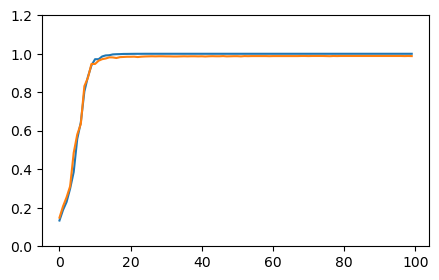

<Figure size 640x480 with 0 Axes>

In [22]:
plot_model_result(result=FC_LN_227, fig_title='FC_LN_227')

In [ ]:
#predictions = model_layer_norm.predict(testX, verbose=False)
#predictions=np.argmax(predictions,axis=1)
#validation_y=np.argmax(testy,axis=1)
#print(confusion_matrix(validation_y, predictions))

## Alexnet configuration

In [27]:
alexnet = keras.Sequential([
    keras.Input(shape=(227, 227, 3)),
    layers.Conv2D(3,(11,11), padding = 'valid', activation = None,strides = 4, name ='conv2d_1'),
    tf.keras.layers.LayerNormalization(),
    layers.Activation('relu'), 
    layers.MaxPooling2D(pool_size=(3,3),padding = 'valid',strides =2, name = 'maxpool_1'),
    layers.Conv2D(3,(5,5), padding = 'same', activation = None,strides = 1, name ='conv2d_2'),
    tf.keras.layers.LayerNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3,3),padding = 'valid',strides =2, name = 'maxpool_2'), 
    layers.Conv2D(3,(3,3), padding = 'same', activation = 'relu',strides = 1, name ='conv2d_3'),
    layers.Conv2D(3,(3,3), padding = 'same', activation = 'relu',strides = 1, name ='conv2d_4'),
    layers.Conv2D(3,(3,3), padding = 'same', activation = 'relu',strides = 1, name ='conv2d_5'),
    layers.MaxPooling2D(pool_size=(3,3),padding = 'valid',strides =2, name = 'maxpool_3'),  
    layers.Flatten(name ='Flatten'),
    layers.Dense(400, activation ='relu',name ='dense1'),
    layers.Dense(400, activation ='relu', name = 'dense2'),
    layers.Dense(10, activation = 'softmax',name = 'dense3'),
    ])
alexnet.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

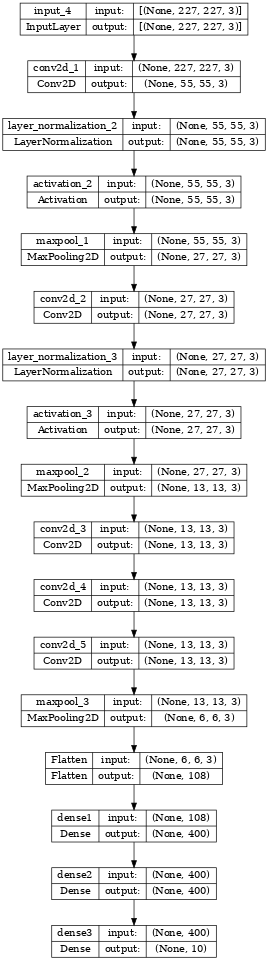

In [28]:
plot_model(alexnet, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='ALEX_227.png')

In [29]:
history = alexnet.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=False, batch_size=500)


In [30]:
ALEX_227 =get_model_result()
ALEX_227.to_csv('ALEX_227.csv', index=False)

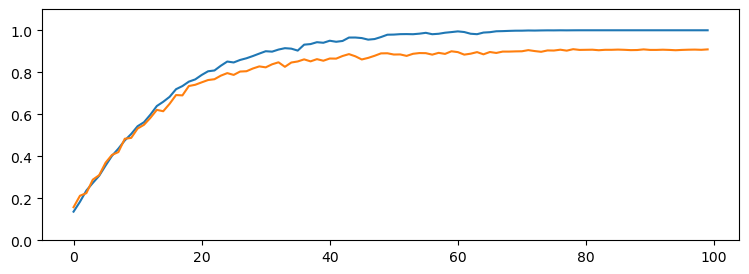

<Figure size 640x480 with 0 Axes>

In [31]:
plot_model_result(result=ALEX_227, fig_title='ALEX_227')